### Import Necessary Module and Set Path 

In [40]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os

In [41]:
import analysis as an

In [42]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('./output/input.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

OperationalError: no such table: info

In [43]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

OperationalError: no such table: info

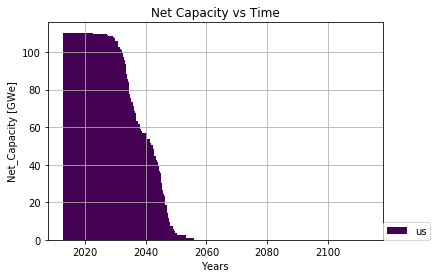

In [39]:
Image('power_plot.png')

['523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665'

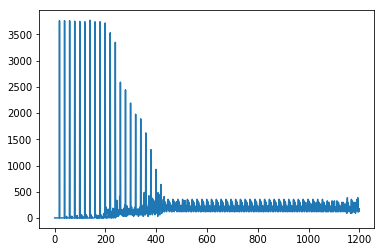

In [27]:
uox = an.get_agent_ids(cur, 'reactor')
influx = an.facility_commodity_flux(cur, uox,
                                         ['uox_waste'],
                                         True, False)
plt.plot(influx['uox_waste'])


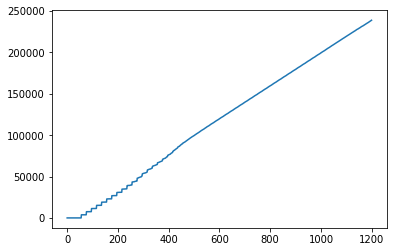

In [34]:

uox_rep = an.get_prototype_id(cur, 'reprocessing')
influx = an.facility_commodity_flux(cur, uox_rep,
                                         ['cooled_uox', 'pre_2013_unf'],
                                         False, True)
total = [x+y for x,y in zip(influx['cooled_uox'], influx['pre_2013_unf'])]
total = influx['cooled_uox']
plt.plot(total)

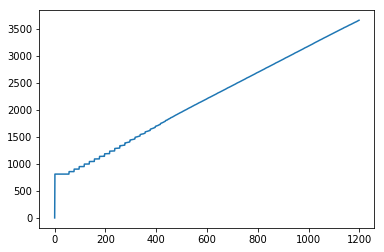

In [29]:
uox_rep = an.get_prototype_id(cur, 'reprocessing')
outflux = an.facility_commodity_flux(cur, uox_rep,
                                         ['lwr_pu'],
                                         True, True)
plt.plot(outflux['lwr_pu'])


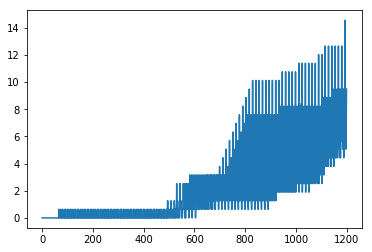

In [30]:
uox_rep = an.get_prototype_id(cur, 'sfr_reprocessing')
outflux = an.facility_commodity_flux(cur, uox_rep,
                                         ['sfr_pu'],
                                         True, False)
plt.plot(outflux['sfr_pu'])


238887.532


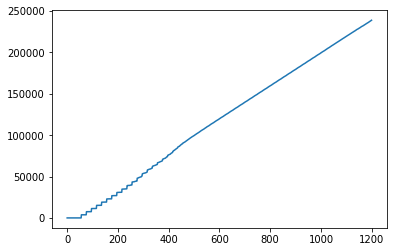

In [31]:
uox_unf = an.get_agent_ids(cur, 'storage')
outflux = an.facility_commodity_flux(cur, uox_unf, ['cooled_uox'], True, True)
plt.plot(outflux['cooled_uox'])
print(outflux['cooled_uox'][-1])

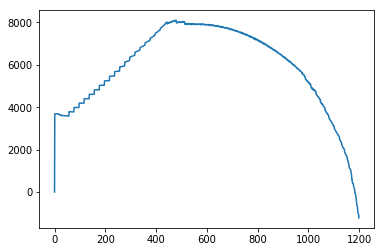

In [32]:
lwr_mixer = an.get_prototype_id(cur, 'sfr_mixer_lwr')
outflux = an.facility_commodity_flux(cur, lwr_mixer,
                                     ['sfr_fuel_legacy'],
                                     True, True)
outflux = np.array(outflux['sfr_fuel_legacy'])
influx = an.facility_commodity_flux(cur, lwr_mixer, ['lwr_pu'], False, True)
influx = np.array(influx['lwr_pu']) / 0.22

plt.plot(influx - outflux)

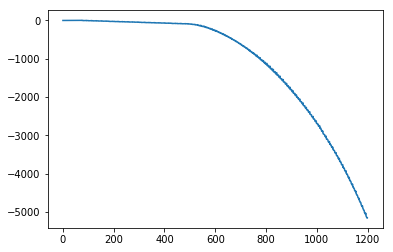

In [33]:
sfr_mixer = an.get_prototype_id(cur, 'sfr_mixer_sfr')
outflux = an.facility_commodity_flux(cur, sfr_mixer,
                                     ['sfr_fuel_new'],
                                     True, True)
outflux = np.array(outflux['sfr_fuel_new'])
influx = an.facility_commodity_flux(cur, sfr_mixer, ['sfr_pu'], False, True)
influx = np.array(influx['sfr_pu']) / 0.22
plt.plot(influx - outflux)